In [156]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import seaborn as sns
import matplotlib.pyplot as plt
import math

# EDA avant division : Pour comprendre et préparer les données.
# ACP après division : Pour éviter une fuite de données.

# 1. Chargement des données


In [157]:
TRAIN_PATH = "./data/spam_data_train.rda"
TEST_PATH = "./data/spam_data_test.rda"

ro.r["load"](TRAIN_PATH)
ro.r["load"](TEST_PATH)

train_data = ro.r["data_train"]
test_data = ro.r["data_test"]

train_df = pandas2ri.rpy2py(train_data)
test_df = pandas2ri.rpy2py(test_data)

In [158]:
print(train_data.head())
# Exemple d'analyse : description statistique
print(train_df.describe())
# liste des colunnes
print(train_df.columns)
#nmbr de lignes et de colonnes
print(train_df.shape)

     word_freq_make word_freq_address word_freq_all word_freq_3d word_freq_our
455             0.0               0.0          0.89            0          1.79
2246            0.0               0.0          0.00            0          0.00
1935            0.0               0.0          0.00            0          0.00
1384            0.0               0.0          0.00            0          1.82
679             0.1               0.1          0.70            0          0.60
4129            0.0               0.0          0.00            0          0.00
     word_freq_over word_freq_remove word_freq_internet word_freq_order
455            0.44             0.00               0.00            0.00
2246           0.00             0.00               0.00            0.00
1935           0.00             0.00               0.00            0.00
1384           0.36             0.36               0.72            0.36
679            0.20             0.40               0.10            1.41
4129           

In [159]:
print(test_df.head())
# Exemple d'analyse : description statistique
print(test_df.describe())
# liste des colunnes
print(test_df.columns)
#nmbr de lignes et de colonnes
print(test_df.shape)

      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
2961            0.00                0.0           0.00          0.00   
2515            0.00                0.0           0.00          0.00   
3246            0.00                0.0           0.00          0.00   
1117            0.58                0.0           0.00         35.46   
2340            0.69                0.0           0.69          0.00   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
2961           0.00             0.0              0.00                0.00   
2515           0.00             0.0              0.00                0.00   
3246           0.00             0.0              0.00                0.00   
1117           0.58             0.0              0.58                0.58   
2340           0.00             0.0              0.00                0.00   

      word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
2961              0.0  

In [160]:
# Calculer le nombre de valeurs manquantes par colonne
sun_null_train_df = train_df.isnull().sum()

# Vérifier s'il y a des colonnes avec des données manquantes
if (sun_null_train_df > 0).any():
    # Afficher les colonnes avec des valeurs manquantes
    print("Les colonnes suivantes ont des données manquantes :")
    print(sun_null_train_df[sun_null_train_df > 0])
else:
    print("Aucune donnée manquante trouvée dans le dataset d'entraînement.")

Aucune donnée manquante trouvée dans le dataset d'entraînement.


In [161]:
#nmbr de lignes et de colonnes
print(train_df.shape)
# liste des colunnes
print(train_df.columns)

# Exemple d'analyse : description statistique
print(train_df.describe())

(2588, 58)
Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_co

## --------------- Analyse des resultats -------------------
### 1. Count :
- Toutes les colonnes ont 2588 valeurs, ce qui signifie qu'il n'y a pas de données manquantes dans les variables analysées. Cela confirme une qualité correcte des données en termes de complétude.

###     2. Mean (moyenne) :
- Les valeurs moyennes des variables comme word_freq_* et char_freq_* sont faibles (typiquement inférieures à 0.3), ce qui indique que les mots ou caractères spécifiques ne représentent qu’une petite proportion dans la majorité des emails.
- Pour les variables liées à la capitalisation (capital_run_length_*), les moyennes montrent que les lettres majuscules ne sont pas très fréquentes en moyenne, avec une moyenne de 52.17 pour la somme totale (capital_run_length_total).

### 3. Standard Deviation (std) :
- Les écarts-types montrent une grande variabilité dans certaines colonnes. Par exemple :
char_freq_* a un écart-type élevé (1.268), indiquant que certains emails contiennent beaucoup de ces caractères spéciaux.
- capital_run_length_total a une variabilité extrême (283.29), ce qui pourrait être influencé par des emails contenant beaucoup de majuscules (souvent caractéristique de spams).

### 4. Min (minimum) :
- Toutes les variables commencent à 0, ce qui est logique : un email peut ne pas contenir un mot spécifique ou des lettres majuscules.

### 5. 25% et 50% (quartiles) :
- Le premier quartile (25%) et la médiane (50%) sont souvent à 0 pour les fréquences (word_freq_*, char_freq_*), indiquant qu’au moins 50% des emails ont très peu ou pas de fréquence de mots/lettres majuscules spécifiques.

### 6. 75% (troisième quartile) :
- La plupart des colonnes restent faibles au troisième quartile, sauf pour certaines comme capital_run_length_total (264), montrant que seulement 25% des emails ont un total de majuscules supérieur à cette valeur. Cela renforce la distinction potentielle entre spam et ham.

### 7. Max (maximum) :
- Les valeurs maximales pour certaines colonnes, comme capital_run_length_total (15,841), révèlent des outliers significatifs. Cela peut correspondre à des spams contenant une grande quantité de majuscules ou des anomalies dans les données.

In [162]:
# 1. Analyser la structure des données
print("=== Informations sur le dataset ===")
print(train_df.info())

=== Informations sur le dataset ===
<class 'pandas.core.frame.DataFrame'>
Index: 2588 entries, 455 to 365
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              2588 non-null   float64
 1   word_freq_address           2588 non-null   float64
 2   word_freq_all               2588 non-null   float64
 3   word_freq_3d                2588 non-null   float64
 4   word_freq_our               2588 non-null   float64
 5   word_freq_over              2588 non-null   float64
 6   word_freq_remove            2588 non-null   float64
 7   word_freq_internet          2588 non-null   float64
 8   word_freq_order             2588 non-null   float64
 9   word_freq_mail              2588 non-null   float64
 10  word_freq_receive           2588 non-null   float64
 11  word_freq_will              2588 non-null   float64
 12  word_freq_people            2588 non-null   float64
 13  w

In [163]:
# 2. Distribution des classes (spam vs ham)
print("\n=== Distribution des classes (label) ===")
print(train_df['label'].value_counts())  # Comptage des classes 0 (ham) et 1 (spam)
print(train_df['label'].value_counts(normalize=True) * 100)  # Pourcentage des classes


=== Distribution des classes (label) ===
label
0    1588
1    1000
Name: count, dtype: int64
label
0    61.360124
1    38.639876
Name: proportion, dtype: float64


# 2. Analyse exploratoire des données (EDA)

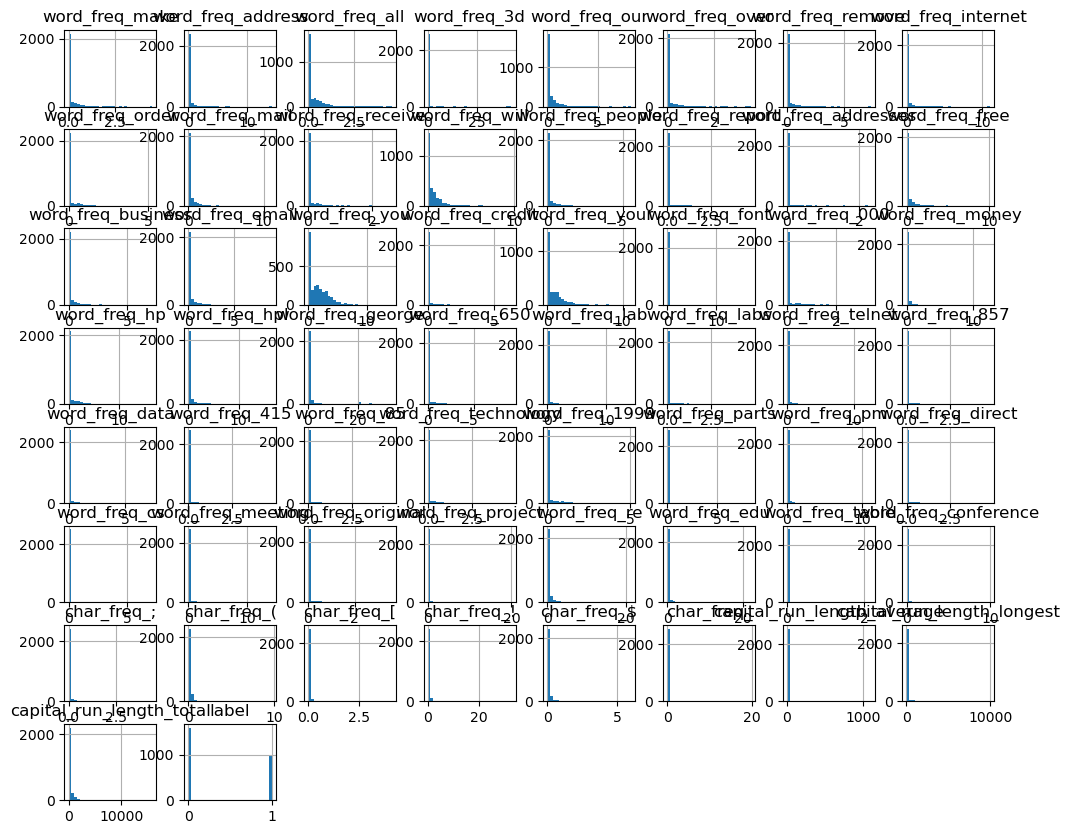

In [164]:
import matplotlib.pyplot as plt
train_df.hist(figsize=(12, 10), bins=30)
plt.show()


<AxesSubplot:>

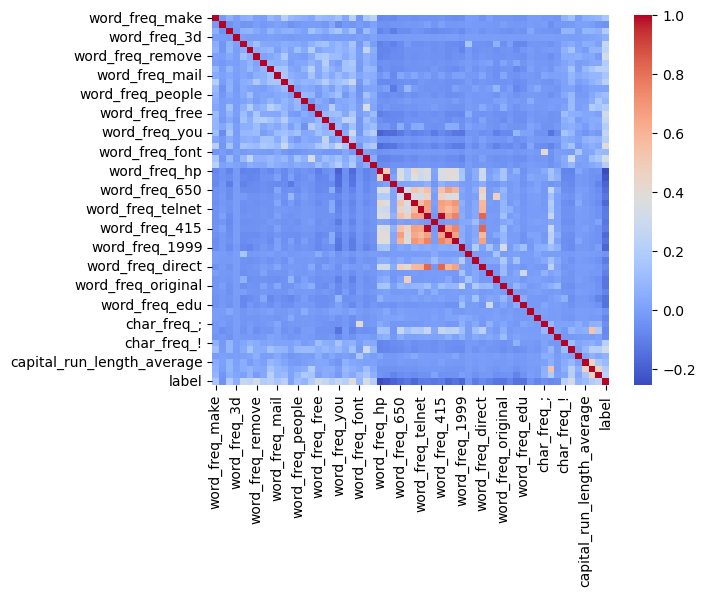

In [165]:
# Matrice de corrélation 
import seaborn as sns
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')


In [166]:
# Relation avec la cible 
correlations_with_target = train_df.corr()['label'].sort_values(ascending=False)
print(correlations_with_target)

label                         1.000000
word_freq_your                0.382897
word_freq_000                 0.340722
word_freq_remove              0.326225
word_freq_free                0.318739
char_freq_$                   0.318005
word_freq_our                 0.272558
word_freq_business            0.266480
word_freq_you                 0.262800
word_freq_over                0.243115
capital_run_length_total      0.240471
word_freq_receive             0.223663
word_freq_order               0.222946
char_freq_!                   0.212928
word_freq_credit              0.207933
word_freq_money               0.206663
word_freq_email               0.198466
word_freq_addresses           0.196146
word_freq_internet            0.193147
capital_run_length_longest    0.192041
word_freq_all                 0.189167
word_freq_make                0.160260
word_freq_mail                0.157411
word_freq_people              0.122571
capital_run_length_average    0.108684
word_freq_font           

In [167]:
# Conserver les features les plus corrélées avec la cible (label)
significant_features = correlations_with_target[abs(correlations_with_target) > 0.2].index
print("Features conservées :")
print(significant_features)
train_cor_df = train_df[significant_features]
train_cor_df.shape

Features conservées :
Index(['label', 'word_freq_your', 'word_freq_000', 'word_freq_remove',
       'word_freq_free', 'char_freq_$', 'word_freq_our', 'word_freq_business',
       'word_freq_you', 'word_freq_over', 'capital_run_length_total',
       'word_freq_receive', 'word_freq_order', 'char_freq_!',
       'word_freq_credit', 'word_freq_money', 'word_freq_hpl', 'word_freq_hp'],
      dtype='object')


(2588, 18)

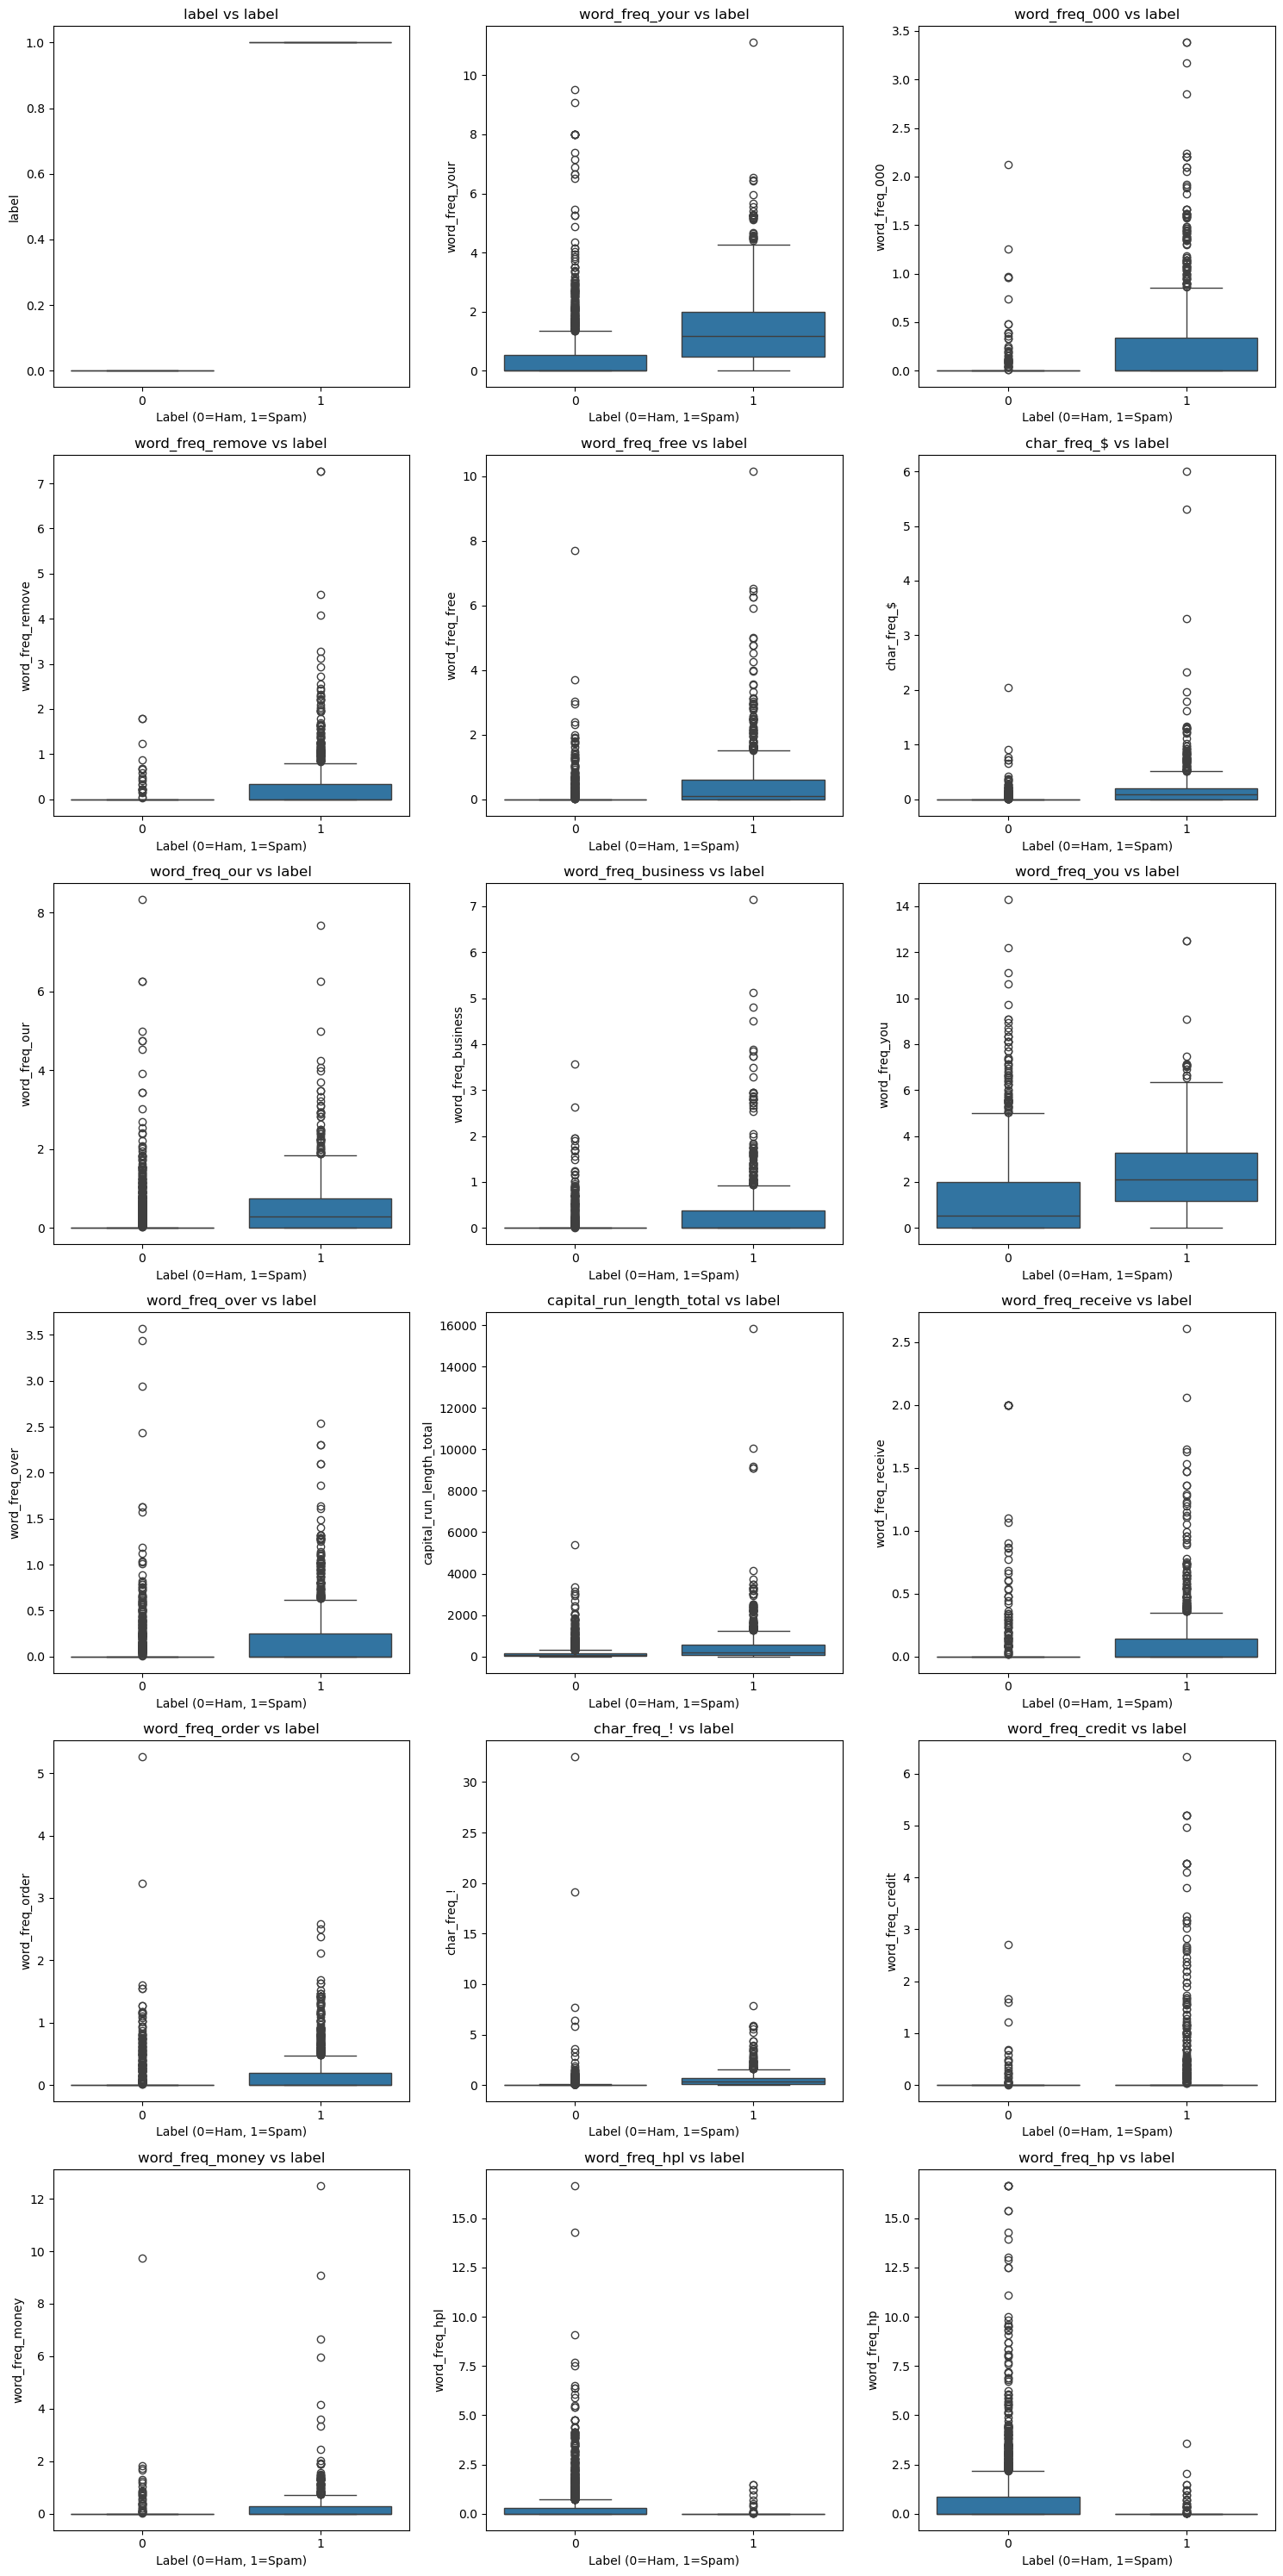

In [168]:
significant_features_label = significant_features.drop('label')
n_features = len(significant_features)
cols = 3  # Nombre de colonnes souhaitées
rows = math.ceil(n_features / cols)  # Calcul du nombre de lignes
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

# Étape 3 : Créer les boxplots
for i, feature in enumerate(significant_features):
    row, col = divmod(i, cols)
    sns.boxplot(x='label', y=feature, data=train_df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs label')
    axes[row, col].set_xlabel('Label (0=Ham, 1=Spam)')
    axes[row, col].set_ylabel(feature)

# Supprimer les axes inutilisés (s'il y a plus de sous-plots que de features)
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

# Ajuster l'espacement entre les plots
plt.tight_layout()
plt.show()

In [169]:
from sklearn.model_selection import train_test_split

# Séparer les caractéristiques et la cible si nécessaire
X = train_cor_df.drop('label', axis=1)  
y = train_cor_df['label']               

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [170]:
# Vérifier les dimensions
print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Train features shape: (2070, 17)
Test features shape: (518, 17)
Train labels shape: (2070,)
Test labels shape: (518,)


# 3. ACP

In [171]:
def plot_acp(X_reduced, vects_sorted, lambdas_sorted, feature_names, label_colors=None, labels=None):
        plt.figure(figsize=(12, 8))

        # Cercle des corrélations
        plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
        plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
        circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=1.5)
        plt.gca().add_artist(circle)

        # Flèches des variables
        for i in range(vects_sorted.shape[1]):
            plt.arrow(0, 0, vects_sorted[0, i], vects_sorted[1, i],
                      color='r', alpha=0.8, head_width=0.03)
            plt.text(vects_sorted[0, i] * 1.1, vects_sorted[1, i] * 1.1,
                     feature_names[i], color='r', ha='center', va='center')

        # Points projetés
        if label_colors is None:
            label_colors = ['blue'] * X_reduced.shape[0]
        scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
                              c=label_colors, alpha=0.6, cmap='viridis', edgecolor='k')
        if labels is not None:
            plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(labels))

        # Configurations du graphique
        plt.title("Cercle des corrélations et projection des observations")
        plt.xlabel(f"Composante principale 1 ({lambdas_sorted[0] / sum(lambdas_sorted) * 100:.2f}%)")
        plt.ylabel(f"Composante principale 2 ({lambdas_sorted[1] / sum(lambdas_sorted) * 100:.2f}%)")
        plt.grid()
        plt.show()

Nombre de composantes principales retenues : 13
Variance expliquée cumulée : 73.87%
Dimensions des données après projection : (13, 2070)


ValueError: 'c' argument has 2070 elements, which is inconsistent with 'x' and 'y' with size 13.

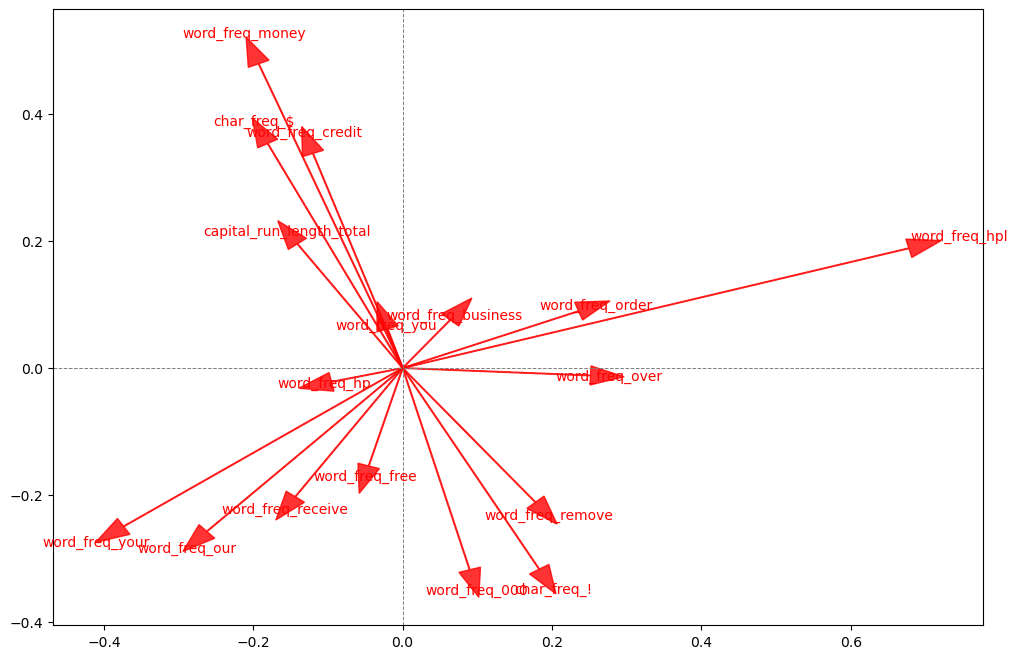

In [172]:
from ACP import ACP

acp = ACP()

# Étape 1 : Centrage des données
X_train_standardized, mean, std = acp.standardize(X_train)

# Étape 2 : Matrice de covariance
cov_matrix = acp.scatter(X_train_standardized) 

# Étape 3 : Calcul des valeurs propres et vecteurs propres
lambdas, lambdas_sorted, vects, vects_sorted = acp.sort(cov_matrix)

# Étape 4 : Sélection du nombre de composantes principales
k, explained_variance, base = acp.fixe_k(lambdas, lambdas_sorted, vects_sorted)

print(f"Nombre de composantes principales retenues : {k}")
print(f"Variance expliquée cumulée : {explained_variance * 100:.2f}%")

# Étape 5 : Projection des données
X_reduced = acp.proj(X_train_standardized, base)
print(f"Dimensions des données après projection : {X_reduced.shape}")

feature_names = X_train.columns.tolist()  

# Labels pour les points
label_colors = y_train.map({0: 'blue', 1: 'orange'})  

# Appel de la fonction de visualisation
plot_acp(X_reduced, vects_sorted, lambdas_sorted, feature_names, label_colors=label_colors, labels=y_train)




# 4. Entraînement des modèles

### 4.1 Régression logistique

In [ ]:
from LogisticRegression import LogisticRegression

# Instancier et entraîner le classificateur de régression logistique
lr_classifier = LogisticRegression()
lr_classifier.fit(X_reduced.values, y_train.values)

# Prédire les étiquettes sur l'ensemble de test
lr_predictions = lr_classifier.predict(X_test.values)

# Calculer l'exactitude
lr_accuracy = lr_classifier.accuracy(y_test.values, lr_predictions)
print(f"L'exactitude du modèle est de {lr_accuracy * 100:.2f}%")